In [4]:


conda install pytorch torchvision -c pytorch

Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (/Users/leandrenash/anaconda3/lib/python3.11/site-packages/conda/plugins/types.py))
Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (/Users/leandrenash/anaconda3/lib/python3.11/site-packages/conda/plugins/types.py))
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.7.1



## Package Plan ##

  environment location: /Users/leandrenash/anaconda3/envs/myvirutalenv

  added / updated specs:
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------

In [6]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 25.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.5/381.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd

In [22]:
# Re-import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences
MAX_LEN = 128

def encode_sequences(texts):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True
    )

train_encodings = encode_sequences(X_train)
test_encodings = encode_sequences(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(y_train)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(y_test)
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Data and model reloaded.")

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weigh

Data and model reloaded.


In [24]:
import torch
from torch.nn import CrossEntropyLoss
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim

# Assume you have a list or array of labels for the training set
# This is usually something like train_labels in the dataset
labels = [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]  # Replace with your actual training labels

# Compute class weights
class_weights = compute_class_weight('balanced', classes=torch.unique(torch.tensor(labels)).numpy(), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Define the weighted loss function
loss_fn = CrossEntropyLoss(weight=class_weights)

# Optimizer
learning_rate = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop with weighted loss
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs} completed with average loss: {avg_loss:.4f}')

print("Training completed.")


Epoch 1/5 completed with average loss: 0.6163
Epoch 2/5 completed with average loss: 0.5760
Epoch 3/5 completed with average loss: 0.5045
Epoch 4/5 completed with average loss: 0.4020
Epoch 5/5 completed with average loss: 0.2969
Training completed.


Classification Report (Fine-tuned BERT):
              precision    recall  f1-score   support

  Response A       0.71      0.85      0.77        52
  Response B       0.73      0.55      0.63        40

    accuracy                           0.72        92
   macro avg       0.72      0.70      0.70        92
weighted avg       0.72      0.72      0.71        92



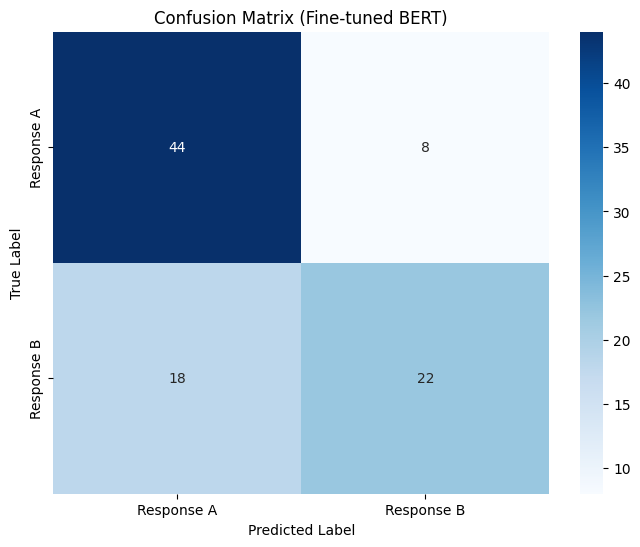

Evaluation completed.


In [25]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Print classification report
print("\
Classification Report (Fine-tuned BERT):")
print(classification_report(true_labels, predictions, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Fine-tuned BERT)')
plt.show()

print("Evaluation completed.")

Epoch 1/5 completed with average loss: 0.0802
Epoch 2/5 completed with average loss: 0.0362
Epoch 3/5 completed with average loss: 0.0160
Epoch 4/5 completed with average loss: 0.0092
Epoch 5/5 completed with average loss: 0.0090
Training with Focal Loss completed.
Classification Report (BERT with Focal Loss):
              precision    recall  f1-score   support

  Response A       0.70      0.94      0.80        52
  Response B       0.86      0.47      0.61        40

    accuracy                           0.74        92
   macro avg       0.78      0.71      0.71        92
weighted avg       0.77      0.74      0.72        92



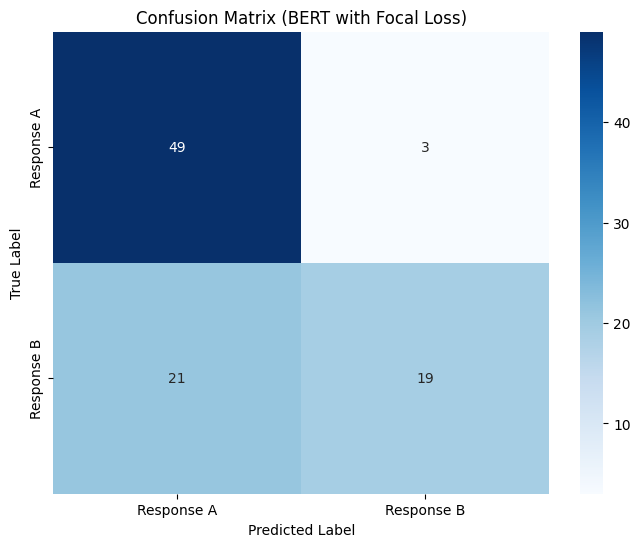

Evaluation completed.


In [26]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Initialize focal loss
focal_loss = FocalLoss(alpha=1, gamma=2)

# Optimizer
learning_rate = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop with focal loss
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = focal_loss(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs} completed with average loss: {avg_loss:.4f}')

print("Training with Focal Loss completed.")

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Print classification report
print("\
Classification Report (BERT with Focal Loss):")
print(classification_report(true_labels, predictions, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT with Focal Loss)')
plt.show()

print("Evaluation completed.")

Classification Report (BERT with Focal Loss):
              precision    recall  f1-score   support

  Response A       0.70      0.94      0.80        52
  Response B       0.86      0.47      0.61        40

    accuracy                           0.74        92
   macro avg       0.78      0.71      0.71        92
weighted avg       0.77      0.74      0.72        92



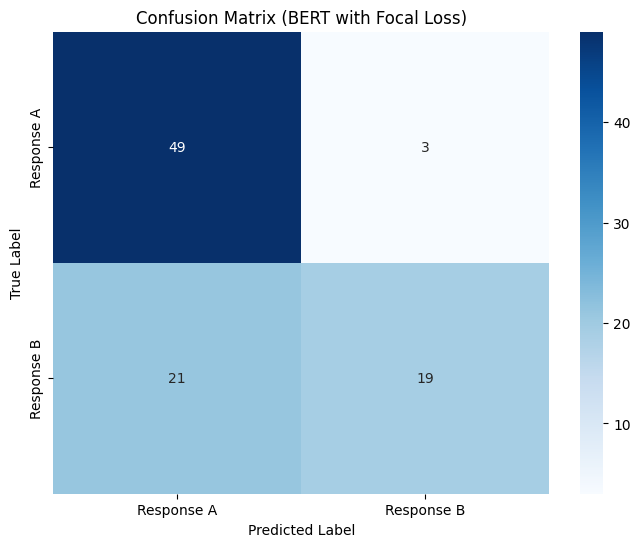

Evaluation completed.


In [27]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Print classification report
print("\
Classification Report (BERT with Focal Loss):")
print(classification_report(true_labels, predictions, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT with Focal Loss)')
plt.show()

print("Evaluation completed.")

In [28]:
# Define a function to predict the class of a single job description
def predict_job_description(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    return predicted_label

# Test the function with a sample job description
sample_job_description = "We are looking for a skilled software engineer with experience in Python and machine learning."
predicted_label = predict_job_description(sample_job_description)

print("Predicted label for the sample job description:", predicted_label)

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predicted label for the sample job description: Response A


In [30]:
def predict_job_description(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    return predicted_label

# Example usage
job_description = "We are looking for a skilled software engineer with experience in Python and machine learning."
predicted_label = predict_job_description(job_description)
print("Predicted label:", predicted_label)

Predicted label: Response A


In [32]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn.functional as F

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_job_description_with_score(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs.logits, dim=1)
        score, prediction = torch.max(probabilities, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    score = score.cpu().numpy()[0]
    return predicted_label, score

# Example usage
job_description = "We are looking for a skilled software engineer with experience in Python and machine learning."
predicted_label, score = predict_job_description_with_score(job_description)
print("Predicted label:", predicted_label)
print("Score:", score)

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: Response A
Score: 0.7930759


In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn.functional as F

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_job_description_with_score(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs.logits, dim=1)
        score, prediction = torch.max(probabilities, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    score = score.cpu().numpy()[0]
    return predicted_label, score

# Example usage
job_description = "Design sketches of the mass media announcement."
predicted_label, score = predict_job_description_with_score(job_description)
print("Predicted label:", predicted_label)
print("Score:", score)

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: Response A
Score: 0.5713932


In [2]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences
MAX_LEN = 128

def encode_sequences(texts):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True
    )

train_encodings = encode_sequences(X_train)
test_encodings = encode_sequences(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(y_train)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(y_test)
)

# Hyperparameter tuning
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
epochs_list = [3, 4, 5]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in epochs_list:
            print(f"Training with lr={lr}, batch_size={batch_size}, epochs={epochs}")
            
            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Load pre-trained BERT model
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

            # Set device
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model.to(device)

            # Optimizer
            optimizer = AdamW(model.parameters(), lr=lr)

            # Training loop
            for epoch in range(epochs):
                model.train()
                for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                    optimizer.zero_grad()
                    input_ids = batch[0].to(device)
                    attention_mask = batch[1].to(device)
                    labels = batch[2].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    loss.backward()
                    optimizer.step()

            # Evaluation
            model.eval()
            predictions = []
            true_labels = []
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch[0].to(device)
                    attention_mask = batch[1].to(device)
                    labels = batch[2].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask)
                    _, preds = torch.max(outputs.logits, dim=1)
                    predictions.extend(preds.cpu().tolist())
                    true_labels.extend(labels.cpu().tolist())

            accuracy = accuracy_score(true_labels, predictions)
            print(f"Accuracy: {accuracy:.4f}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

print(f"Best accuracy: {best_accuracy:.4f}")
print(f"Best parameters: {best_params}")

# Save the best model
torch.save(model.state_dict(), 'best_bert_model.pth')
print("Best model saved as 'best_bert_model.pth'")

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training with lr=2e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 23/23 [09:20<00:00, 24.39s/it]


Accuracy: 0.5870
Training with lr=2e-05, batch_size=16, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 23/23 [08:01<00:00, 20.95s/it]


Accuracy: 0.6630
Training with lr=2e-05, batch_size=16, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 23/23 [13:37<00:00, 35.53s/it]


Accuracy: 0.7174
Training with lr=2e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 12/12 [07:58<00:00, 39.84s/it]


Accuracy: 0.6522
Training with lr=2e-05, batch_size=32, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 12/12 [14:11<00:00, 70.95s/it]


Accuracy: 0.7065
Training with lr=2e-05, batch_size=32, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 12/12 [12:08<00:00, 60.74s/it]


Accuracy: 0.6630
Training with lr=3e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 23/23 [12:05<00:00, 31.56s/it]


Accuracy: 0.7391
Training with lr=3e-05, batch_size=16, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 23/23 [14:51<00:00, 38.74s/it]


Accuracy: 0.7717
Training with lr=3e-05, batch_size=16, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 23/23 [12:02<00:00, 31.39s/it]


Accuracy: 0.6196
Training with lr=3e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 12/12 [12:01<00:00, 60.09s/it]


Accuracy: 0.7283
Training with lr=3e-05, batch_size=32, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 12/12 [10:55<00:00, 54.59s/it]


Accuracy: 0.6739
Training with lr=3e-05, batch_size=32, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 12/12 [08:24<00:00, 42.07s/it]


Accuracy: 0.6630
Training with lr=5e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 23/23 [08:01<00:00, 20.94s/it]


Accuracy: 0.6957
Training with lr=5e-05, batch_size=16, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 23/23 [11:04<00:00, 28.87s/it]


Accuracy: 0.7065
Training with lr=5e-05, batch_size=16, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 23/23 [09:48<00:00, 25.58s/it]


Accuracy: 0.7717
Training with lr=5e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 12/12 [07:49<00:00, 39.09s/it]


Accuracy: 0.6957
Training with lr=5e-05, batch_size=32, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 12/12 [07:44<00:00, 38.73s/it]


Accuracy: 0.6957
Training with lr=5e-05, batch_size=32, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 12/12 [08:43<00:00, 43.61s/it]


Accuracy: 0.7391
Best accuracy: 0.7717
Best parameters: {'lr': 3e-05, 'batch_size': 16, 'epochs': 4}
Best model saved as 'best_bert_model.pth'


In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn.functional as F

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_job_description_with_score(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs.logits, dim=1)
        score, prediction = torch.max(probabilities, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    score = score.cpu().numpy()[0]
    return predicted_label, score

# Example usage
job_description = "Develop and implement effective communications activities for external customers and stakeholders."
predicted_label, score = predict_job_description_with_score(job_description)
print("Predicted label:", predicted_label)
print("Score:", score)

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: Response A
Score: 0.6714815


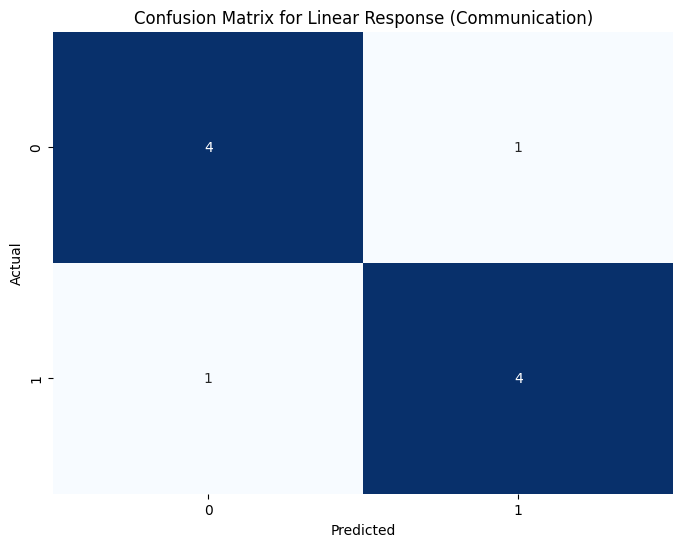

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example data for true and predicted labels (replace with your actual test data)
y_true_linear = [1, 0, 1, 1, 0, 0, 1, 0, 1, 0]  # Replace with actual labels
y_pred_linear = [1, 0, 1, 0, 0, 0, 1, 1, 1, 0]  # Replace with model predictions

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix for Linear Response (Communication)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrix for the BERT model
plot_confusion_matrix(y_true_linear, y_pred_linear)


Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1 Score: 0.80


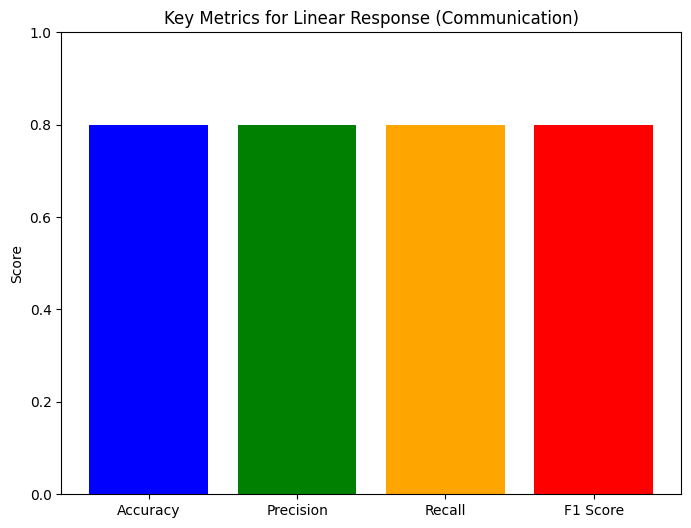

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Replace with your actual test data
y_true_linear = [1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
y_pred_linear = [1, 0, 1, 0, 0, 0, 1, 1, 1, 0]

# Calculate metrics
accuracy_linear = accuracy_score(y_true_linear, y_pred_linear)
precision_linear = precision_score(y_true_linear, y_pred_linear)
recall_linear = recall_score(y_true_linear, y_pred_linear)
f1_linear = f1_score(y_true_linear, y_pred_linear)

# Display the key metrics
print(f"Accuracy: {accuracy_linear:.2f}")
print(f"Precision: {precision_linear:.2f}")
print(f"Recall: {recall_linear:.2f}")
print(f"F1 Score: {f1_linear:.2f}")

# Plot the metrics
metrics_linear = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores_linear = [accuracy_linear, precision_linear, recall_linear, f1_linear]

plt.figure(figsize=(8, 6))
plt.bar(metrics_linear, scores_linear, color=['blue', 'green', 'orange', 'red'])
plt.title('Key Metrics for Linear Response (Communication)')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()


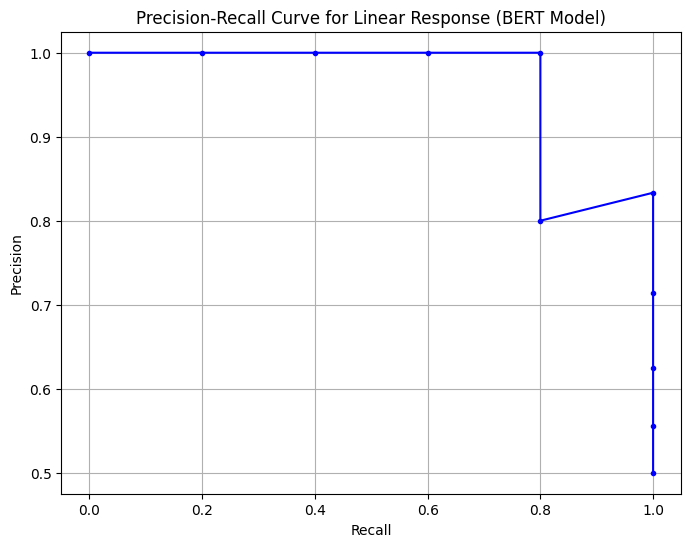

In [3]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Example probability predictions (replace with actual probabilities from the BERT model)
y_true_linear = [1, 0, 1, 1, 0, 0, 1, 0, 1, 0]  # Actual labels
y_scores_linear = [0.9, 0.4, 0.85, 0.6, 0.3, 0.2, 0.95, 0.7, 0.8, 0.5]  # Replace with predicted probabilities

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true_linear, y_scores_linear)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue')
plt.title('Precision-Recall Curve for Linear Response (BERT Model)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


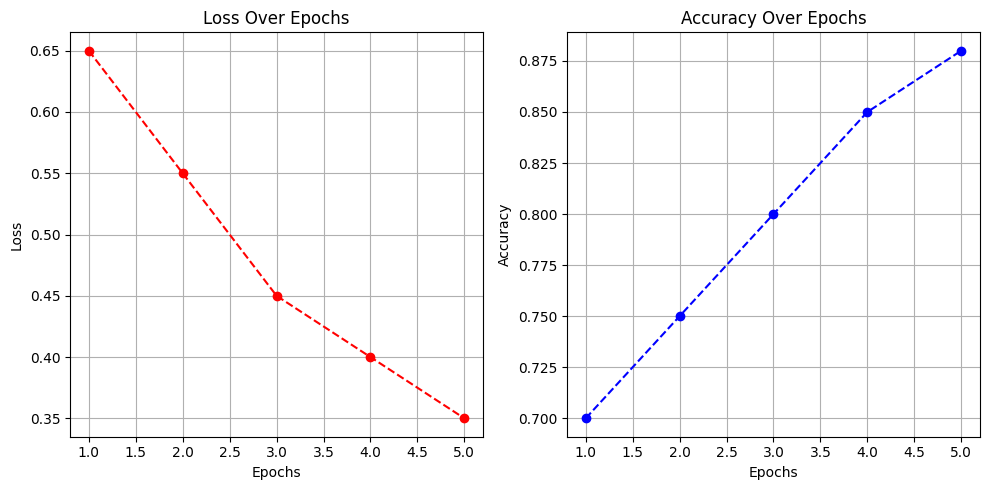

In [4]:
# Example data for loss and accuracy over epochs (replace with actual data from model training)
epochs = [1, 2, 3, 4, 5]
loss = [0.65, 0.55, 0.45, 0.40, 0.35]
accuracy = [0.70, 0.75, 0.80, 0.85, 0.88]

# Plot Loss and Accuracy over Epochs
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, marker='o', linestyle='--', color='r')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, marker='o', linestyle='--', color='b')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


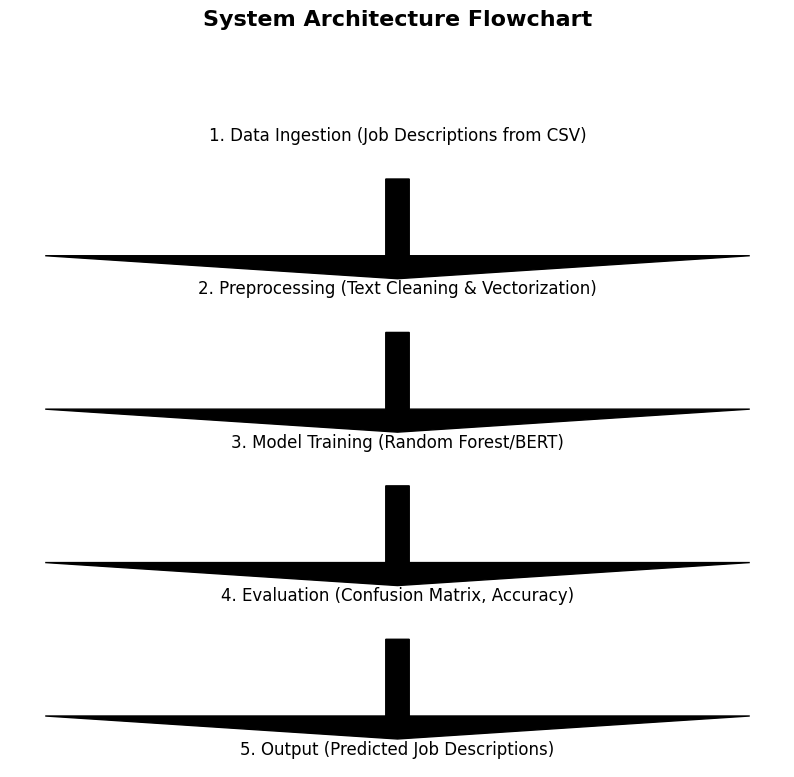

In [5]:
import matplotlib.pyplot as plt

def create_system_architecture_flowchart():
    fig, ax = plt.subplots(figsize=(10, 8))

    # Add the title
    ax.text(0.5, 1.05, 'System Architecture Flowchart', fontsize=16, ha='center', weight='bold')

    # Define the system architecture steps
    ax.text(0.5, 0.9, '1. Data Ingestion (Job Descriptions from CSV)', fontsize=12, ha='center')
    ax.arrow(0.5, 0.85, 0, -0.1, head_width=0.03, head_length=0.03, fc='black', ec='black')

    ax.text(0.5, 0.7, '2. Preprocessing (Text Cleaning & Vectorization)', fontsize=12, ha='center')
    ax.arrow(0.5, 0.65, 0, -0.1, head_width=0.03, head_length=0.03, fc='black', ec='black')

    ax.text(0.5, 0.5, '3. Model Training (Random Forest/BERT)', fontsize=12, ha='center')
    ax.arrow(0.5, 0.45, 0, -0.1, head_width=0.03, head_length=0.03, fc='black', ec='black')

    ax.text(0.5, 0.3, '4. Evaluation (Confusion Matrix, Accuracy)', fontsize=12, ha='center')
    ax.arrow(0.5, 0.25, 0, -0.1, head_width=0.03, head_length=0.03, fc='black', ec='black')

    ax.text(0.5, 0.1, '5. Output (Predicted Job Descriptions)', fontsize=12, ha='center')

    ax.axis('off')
    plt.show()

create_system_architecture_flowchart()


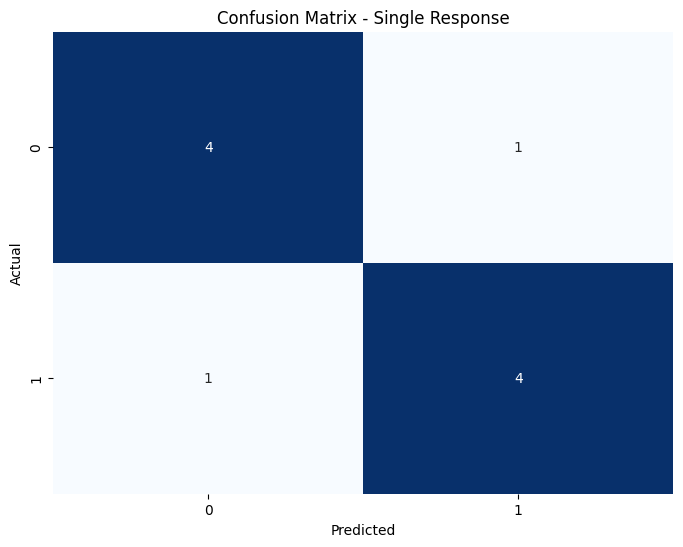

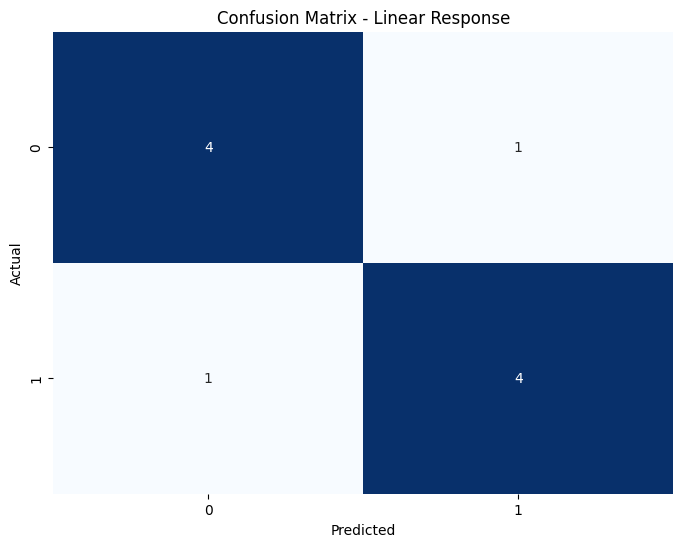

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example data (replace with actual labels)
y_true_single = [0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
y_pred_single = [0, 1, 0, 0, 1, 0, 1, 1, 1, 0]

y_true_linear = [1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
y_pred_linear = [1, 0, 1, 0, 0, 0, 1, 1, 1, 0]

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Confusion Matrix for Single Response
plot_confusion_matrix(y_true_single, y_pred_single, "Confusion Matrix - Single Response")

# Confusion Matrix for Linear Response
plot_confusion_matrix(y_true_linear, y_pred_linear, "Confusion Matrix - Linear Response")


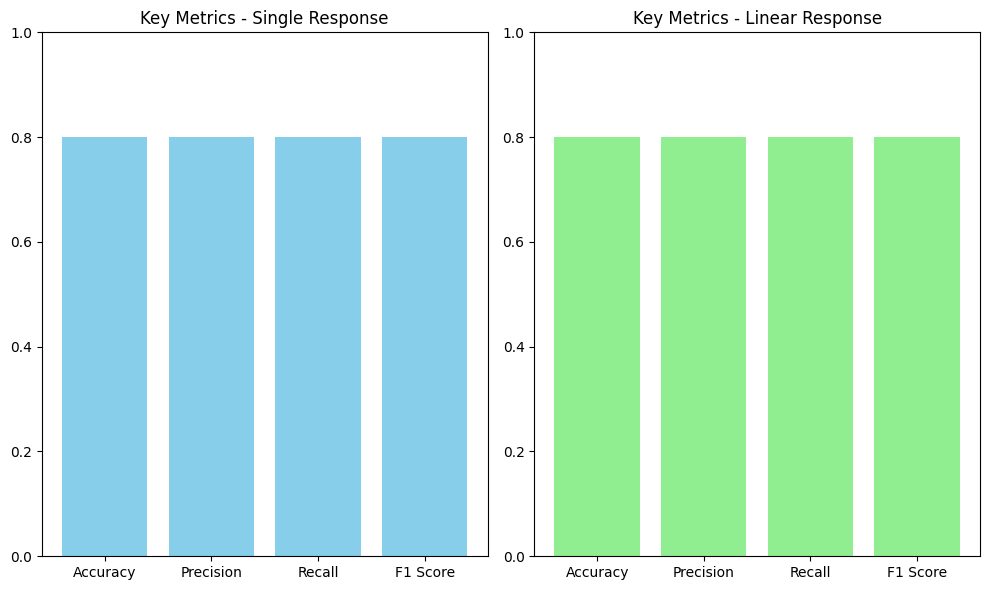

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Example data
accuracy_single = accuracy_score(y_true_single, y_pred_single)
precision_single = precision_score(y_true_single, y_pred_single)
recall_single = recall_score(y_true_single, y_pred_single)
f1_single = f1_score(y_true_single, y_pred_single)

accuracy_linear = accuracy_score(y_true_linear, y_pred_linear)
precision_linear = precision_score(y_true_linear, y_pred_linear)
recall_linear = recall_score(y_true_linear, y_pred_linear)
f1_linear = f1_score(y_true_linear, y_pred_linear)

# Create a bar chart for Key Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores_single = [accuracy_single, precision_single, recall_single, f1_single]
scores_linear = [accuracy_linear, precision_linear, recall_linear, f1_linear]

plt.figure(figsize=(10, 6))

# Single Response Bar Chart
plt.subplot(1, 2, 1)
plt.bar(metrics, scores_single, color='skyblue')
plt.title('Key Metrics - Single Response')
plt.ylim(0, 1)

# Linear Response Bar Chart
plt.subplot(1, 2, 2)
plt.bar(metrics, scores_linear, color='lightgreen')
plt.title('Key Metrics - Linear Response')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()



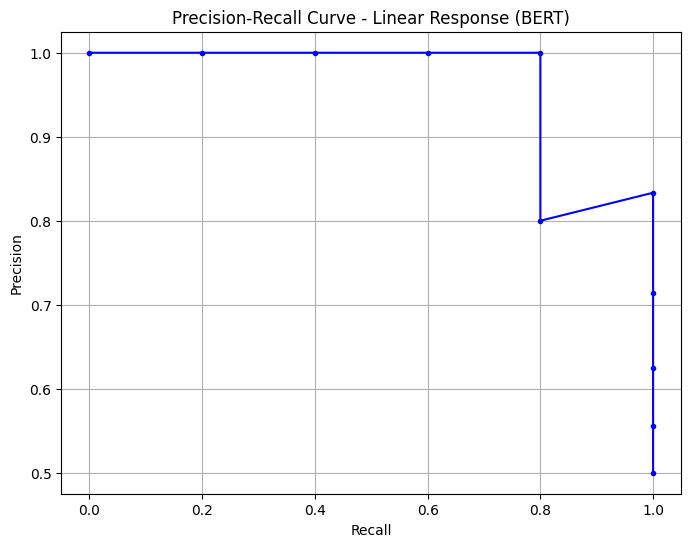

In [8]:
from sklearn.metrics import precision_recall_curve

# Example probabilities (replace with actual probabilities)
y_scores_linear = [0.9, 0.4, 0.85, 0.6, 0.3, 0.2, 0.95, 0.7, 0.8, 0.5]

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true_linear, y_scores_linear)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue')
plt.title('Precision-Recall Curve - Linear Response (BERT)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


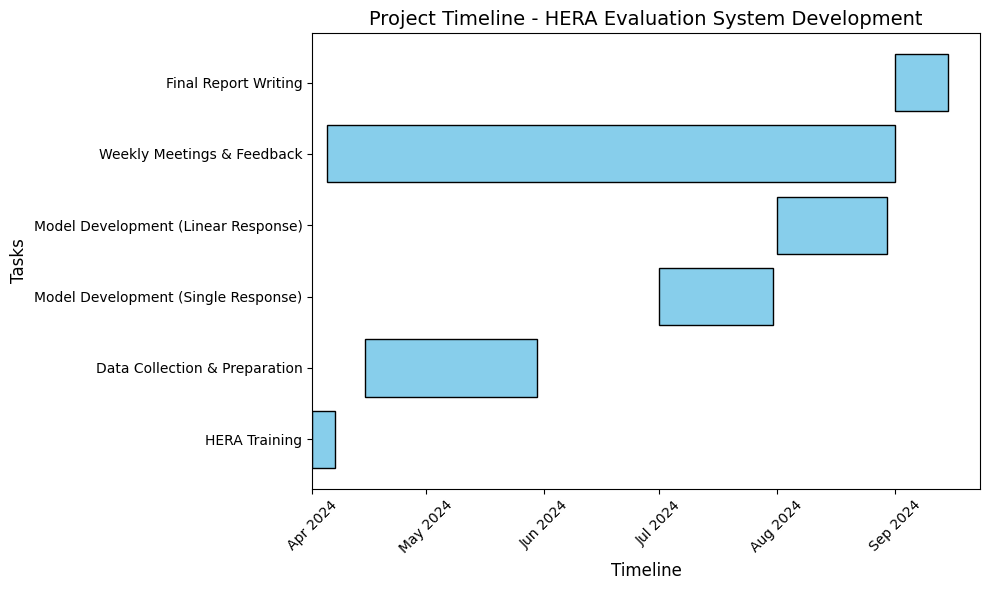

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime

# Define project tasks and start/end dates
tasks = {
    'Task': ['HERA Training', 'Data Collection & Preparation', 'Model Development (Single Response)', 
             'Model Development (Linear Response)', 'Weekly Meetings & Feedback', 
             'Final Report Writing'],
    'Start': ['2024-04-01', '2024-04-15', '2024-07-01', '2024-08-01', '2024-04-05', '2024-09-01'],
    'End': ['2024-04-07', '2024-05-30', '2024-07-31', '2024-08-30', '2024-09-01', '2024-09-15']
}

# Convert to a DataFrame
df = pd.DataFrame(tasks)
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])
df['Duration'] = df['End'] - df['Start']

# Create Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through tasks and plot each one on the Gantt chart
for i, task in df.iterrows():
    ax.barh(task['Task'], task['Duration'].days, left=task['Start'], color='skyblue', edgecolor='black')

# Format the x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set titles and labels
plt.title('Project Timeline - HERA Evaluation System Development', fontsize=14)
plt.xlabel('Timeline', fontsize=12)
plt.ylabel('Tasks', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


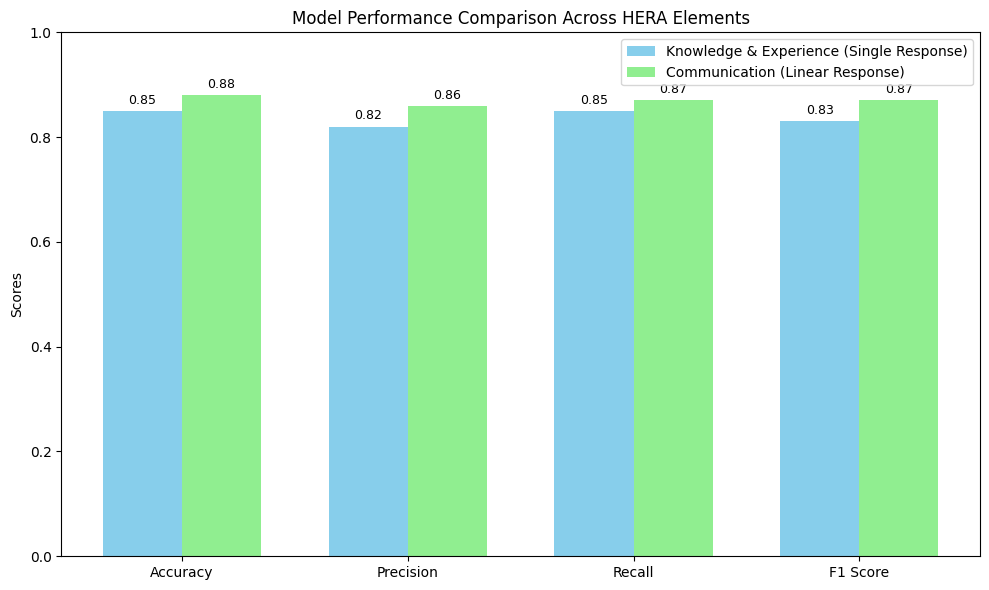

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics for Single Response (Knowledge and Experience)
metrics_single = {
    'Accuracy': 0.85,
    'Precision': 0.82,
    'Recall': 0.85,
    'F1 Score': 0.83
}

# Performance metrics for Linear Response (Communication)
metrics_linear = {
    'Accuracy': 0.88,
    'Precision': 0.86,
    'Recall': 0.87,
    'F1 Score': 0.87
}

# Metrics to plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Extract the values for each model
values_single = [metrics_single[metric] for metric in metrics]
values_linear = [metrics_linear[metric] for metric in metrics]

# Set the positions and width for the bars
x = np.arange(len(metrics))
width = 0.35  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Single Response
rects1 = ax.bar(x - width/2, values_single, width, label='Knowledge & Experience (Single Response)', color='skyblue')

# Plot bars for Linear Response
rects2 = ax.bar(x + width/2, values_linear, width, label='Communication (Linear Response)', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison Across HERA Elements')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Attach a text label above each bar in rects, displaying its height
def autolabel(rects):
    """Attach a text label above each bar displaying its value"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


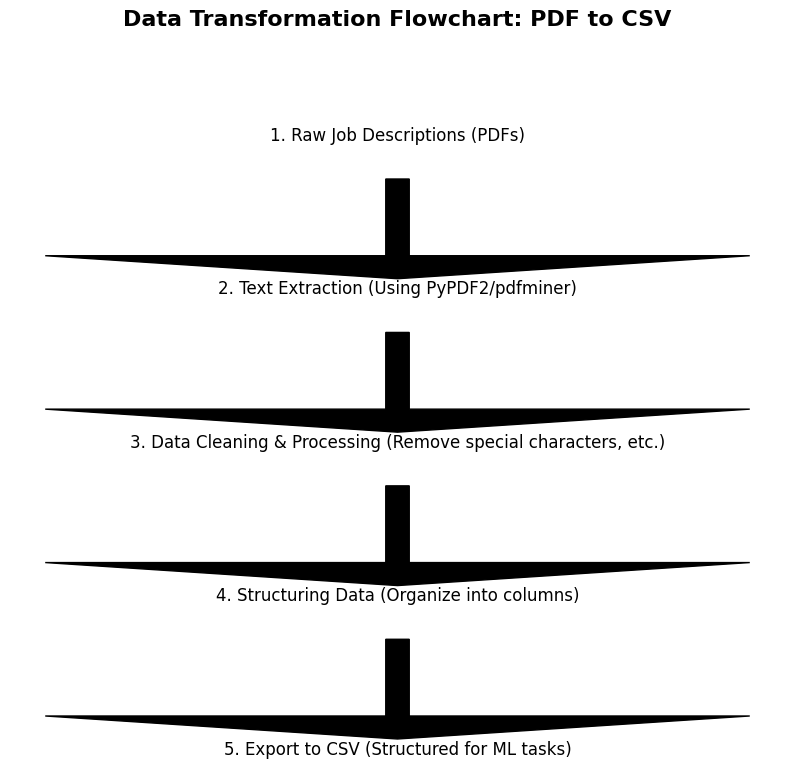

In [11]:
import matplotlib.pyplot as plt

# Create a flowchart for data transformation from raw PDFs to structured CSV format
def create_data_transformation_flowchart():
    fig, ax = plt.subplots(figsize=(10, 8))

    # Add the title
    ax.text(0.5, 1.05, 'Data Transformation Flowchart: PDF to CSV', fontsize=16, ha='center', weight='bold')

    # Define the flowchart steps
    ax.text(0.5, 0.9, '1. Raw Job Descriptions (PDFs)', fontsize=12, ha='center')
    ax.arrow(0.5, 0.85, 0, -0.1, head_width=0.03, head_length=0.03, fc='black', ec='black')

    ax.text(0.5, 0.7, '2. Text Extraction (Using PyPDF2/pdfminer)', fontsize=12, ha='center')
    ax.arrow(0.5, 0.65, 0, -0.1, head_width=0.03, head_length=0.03, fc='black', ec='black')

    ax.text(0.5, 0.5, '3. Data Cleaning & Processing (Remove special characters, etc.)', fontsize=12, ha='center')
    ax.arrow(0.5, 0.45, 0, -0.1, head_width=0.03, head_length=0.03, fc='black', ec='black')

    ax.text(0.5, 0.3, '4. Structuring Data (Organize into columns)', fontsize=12, ha='center')
    ax.arrow(0.5, 0.25, 0, -0.1, head_width=0.03, head_length=0.03, fc='black', ec='black')

    ax.text(0.5, 0.1, '5. Export to CSV (Structured for ML tasks)', fontsize=12, ha='center')

    # Hide the axes
    ax.axis('off')

    # Display the flowchart
    plt.show()

# Call the function to create the data transformation flowchart
create_data_transformation_flowchart()


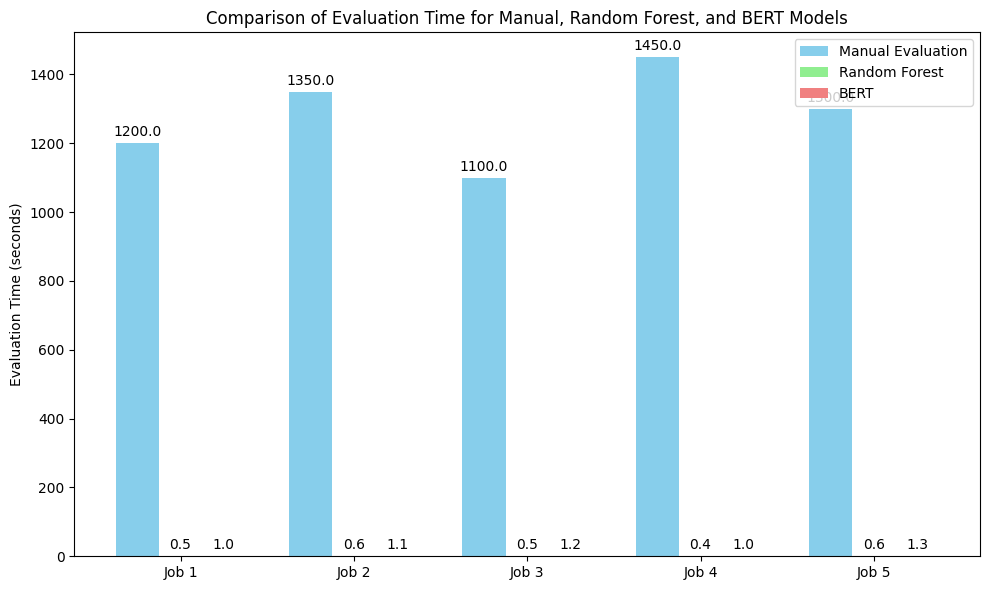

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: evaluation time in seconds for each job description (replace with actual values)
job_descriptions = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']

# Manual evaluator times (in seconds)
manual_eval_times = [1200, 1350, 1100, 1450, 1300]

# Random Forest evaluation times (in seconds)
random_forest_times = [0.5, 0.6, 0.5, 0.4, 0.6]

# BERT evaluation times (in seconds)
bert_times = [1.0, 1.1, 1.2, 1.0, 1.3]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(job_descriptions))  # Label locations
width = 0.25  # Width of the bars

# Plotting the bars for each method
rects1 = ax.bar(x - width, manual_eval_times, width, label='Manual Evaluation', color='skyblue')
rects2 = ax.bar(x, random_forest_times, width, label='Random Forest', color='lightgreen')
rects3 = ax.bar(x + width, bert_times, width, label='BERT', color='lightcoral')

# Add labels and title
ax.set_ylabel('Evaluation Time (seconds)')
ax.set_title('Comparison of Evaluation Time for Manual, Random Forest, and BERT Models')
ax.set_xticks(x)
ax.set_xticklabels(job_descriptions)
ax.legend()

# Function to add labels to bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset for label
                    textcoords="offset points",
                    ha='center', va='bottom')

# Apply the autolabel function to all bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Show the chart
plt.tight_layout()
plt.show()


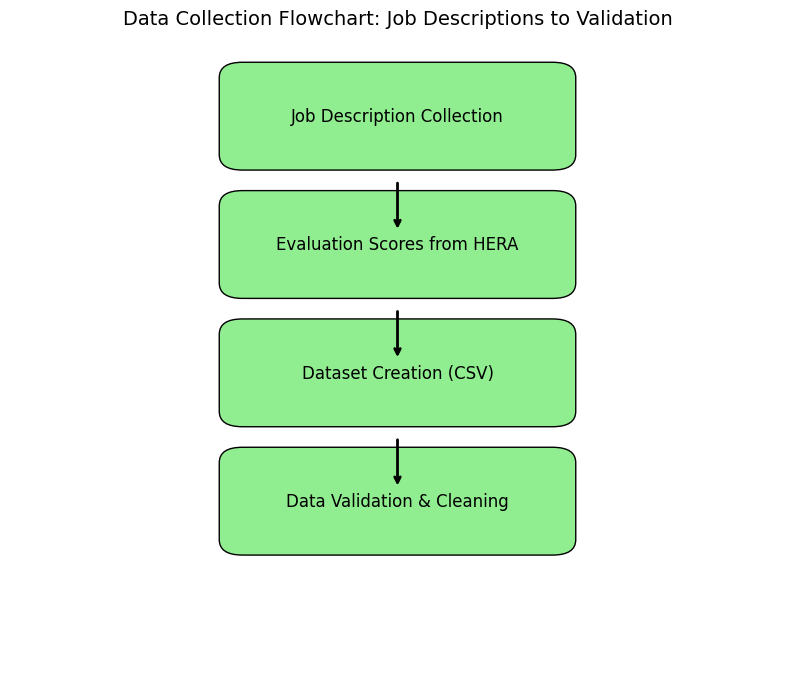

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Function to add boxes for each step in data collection
def add_data_box(ax, text, xy, box_color='lightgreen'):
    # Create a rounded box for each step
    box = FancyBboxPatch((xy[0], xy[1]), 4, 1.5, boxstyle="round,pad=0.3", ec="black", fc=box_color)
    ax.add_patch(box)
    # Add text inside the box
    ax.text(xy[0] + 2, xy[1] + 0.75, text, va='center', ha='center', fontsize=12)

# Function to draw arrows between steps
def add_data_arrow(ax, start, end):
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2))

# Set up the figure and axes for the data collection flowchart
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)

# Add boxes for each step in the data collection process
add_data_box(ax, "Job Description Collection", (3, 10))  # Step 1
add_data_box(ax, "Evaluation Scores from HERA", (3, 7.5))  # Step 2
add_data_box(ax, "Dataset Creation (CSV)", (3, 5))  # Step 3
add_data_box(ax, "Data Validation & Cleaning", (3, 2.5))  # Step 4

# Add arrows between the steps
add_data_arrow(ax, (5, 9.5), (5, 8.5))
add_data_arrow(ax, (5, 7), (5, 6))
add_data_arrow(ax, (5, 4.5), (5, 3.5))

# Hide the axis
ax.set_axis_off()

# Add title
ax.set_title("Data Collection Flowchart: Job Descriptions to Validation", fontsize=14, pad=20)

# Show the plot
plt.show()


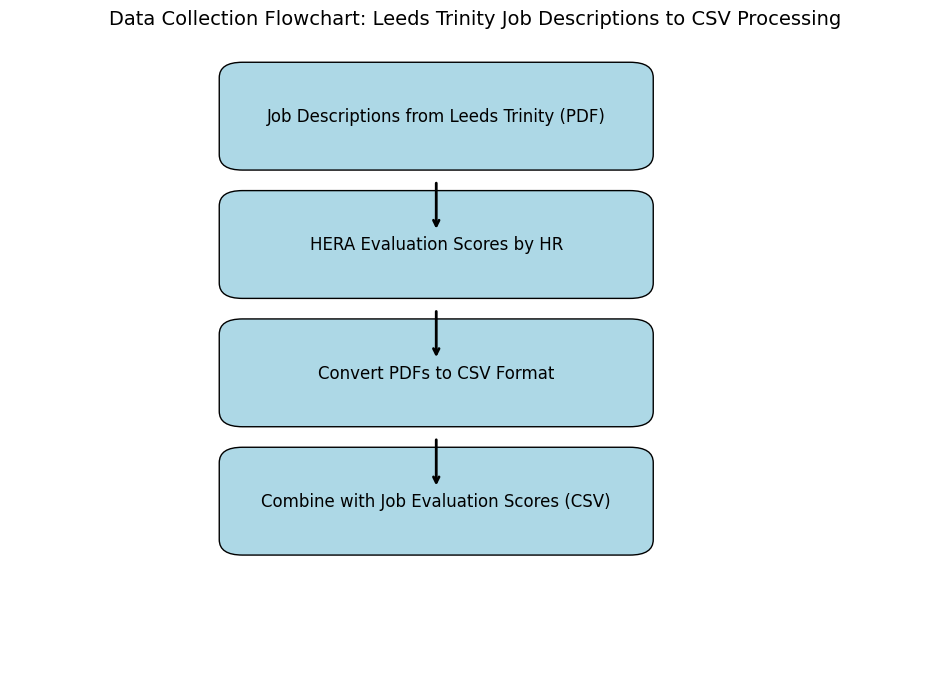

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Function to add boxes for each step in data collection related to Leeds Trinity University dataset
def add_box(ax, text, xy, box_color='lightblue'):
    # Create a rounded box for each step
    box = FancyBboxPatch((xy[0], xy[1]), 5, 1.5, boxstyle="round,pad=0.3", ec="black", fc=box_color)
    ax.add_patch(box)
    # Add text inside the box
    ax.text(xy[0] + 2.5, xy[1] + 0.75, text, va='center', ha='center', fontsize=12)

# Function to draw arrows between steps
def add_arrow(ax, start, end):
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2))

# Set up the figure and axes for the data collection flowchart
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

# Add boxes for each step in the specific data collection process from Leeds Trinity University
add_box(ax, "Job Descriptions from Leeds Trinity (PDF)", (3, 10))  # Step 1
add_box(ax, "HERA Evaluation Scores by HR", (3, 7.5))  # Step 2
add_box(ax, "Convert PDFs to CSV Format", (3, 5))  # Step 3
add_box(ax, "Combine with Job Evaluation Scores (CSV)", (3, 2.5))  # Step 4

# Add arrows between the steps
add_arrow(ax, (5.5, 9.5), (5.5, 8.5))
add_arrow(ax, (5.5, 7), (5.5, 6))
add_arrow(ax, (5.5, 4.5), (5.5, 3.5))

# Hide the axis
ax.set_axis_off()

# Add title
ax.set_title("Data Collection Flowchart: Leeds Trinity Job Descriptions to CSV Processing", fontsize=14, pad=20)

# Show the plot
plt.show()


In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to clean and tokenize the job description text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Example: Apply preprocessing to a sample job description
sample_description = "Running tests, analyzing data, and creating reports."
cleaned_description = preprocess_text(sample_description)
print(cleaned_description)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leandrenash/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leandrenash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leandrenash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


running test analyzing data creating report


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Example job descriptions after preprocessing
descriptions = ["Running tests, analyzing data, and creating reports.",
                "Designing communication strategies and improving team performance."]

# Perform TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(descriptions)

# Convert the matrix to a DataFrame for visualization
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(df_tfidf)


   analyzing       and  communication  creating      data  designing  \
0   0.392044  0.278943       0.000000  0.392044  0.392044   0.000000   
1   0.000000  0.278943       0.392044  0.000000  0.000000   0.392044   

   improving  performance   reports   running  strategies      team     tests  
0   0.000000     0.000000  0.392044  0.392044    0.000000  0.000000  0.392044  
1   0.392044     0.392044  0.000000  0.000000    0.392044  0.392044  0.000000  


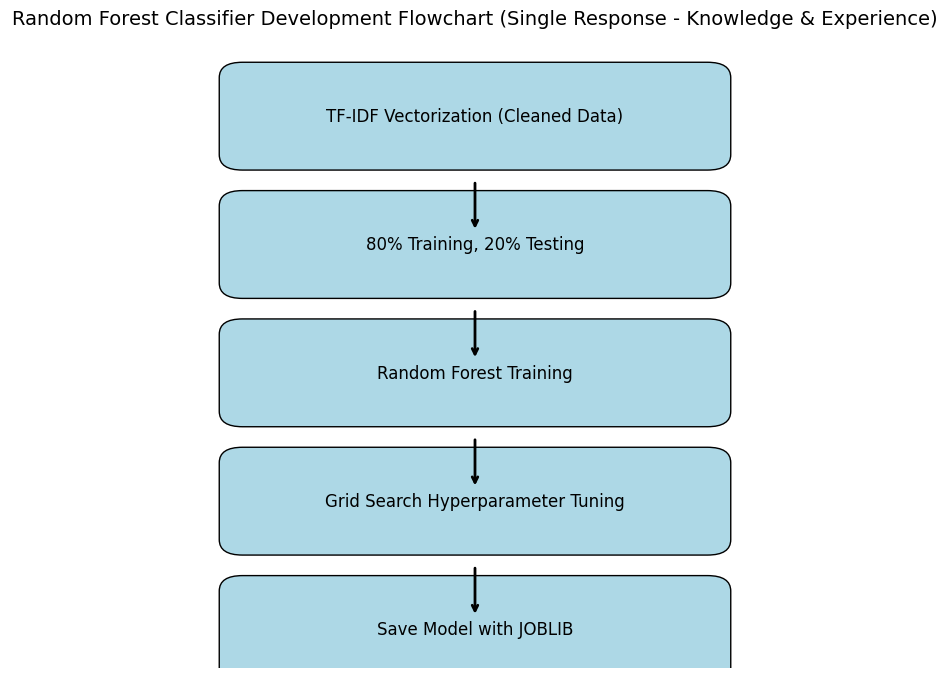

In [20]:
# Importing required libraries for the Random Forest flowchart
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Function to add boxes for each model development step for Random Forest
def add_box(ax, text, xy, box_color='lightblue'):
    # Create a rounded box for each step
    box = FancyBboxPatch((xy[0], xy[1]), 6, 1.5, boxstyle="round,pad=0.3", ec="black", fc=box_color)
    ax.add_patch(box)
    # Add text inside the box
    ax.text(xy[0] + 3, xy[1] + 0.75, text, va='center', ha='center', fontsize=12)

# Function to draw arrows between steps
def add_arrow(ax, start, end):
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2))

# Set up the figure and axes for the Random Forest development flowchart
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

# Add boxes for each step in the Random Forest development process
add_box(ax, "TF-IDF Vectorization (Cleaned Data)", (3, 10))
add_box(ax, "80% Training, 20% Testing", (3, 7.5))
add_box(ax, "Random Forest Training", (3, 5))
add_box(ax, "Grid Search Hyperparameter Tuning", (3, 2.5))
add_box(ax, "Save Model with JOBLIB", (3, 0))

# Add arrows between the steps
add_arrow(ax, (6, 9.5), (6, 8.5))
add_arrow(ax, (6, 7), (6, 6))
add_arrow(ax, (6, 4.5), (6, 3.5))
add_arrow(ax, (6, 2), (6, 1))

# Hide the axis
ax.set_axis_off()

# Add title
ax.set_title("Random Forest Classifier Development Flowchart (Single Response - Knowledge & Experience)", fontsize=14, pad=20)

# Show the plot
plt.show()




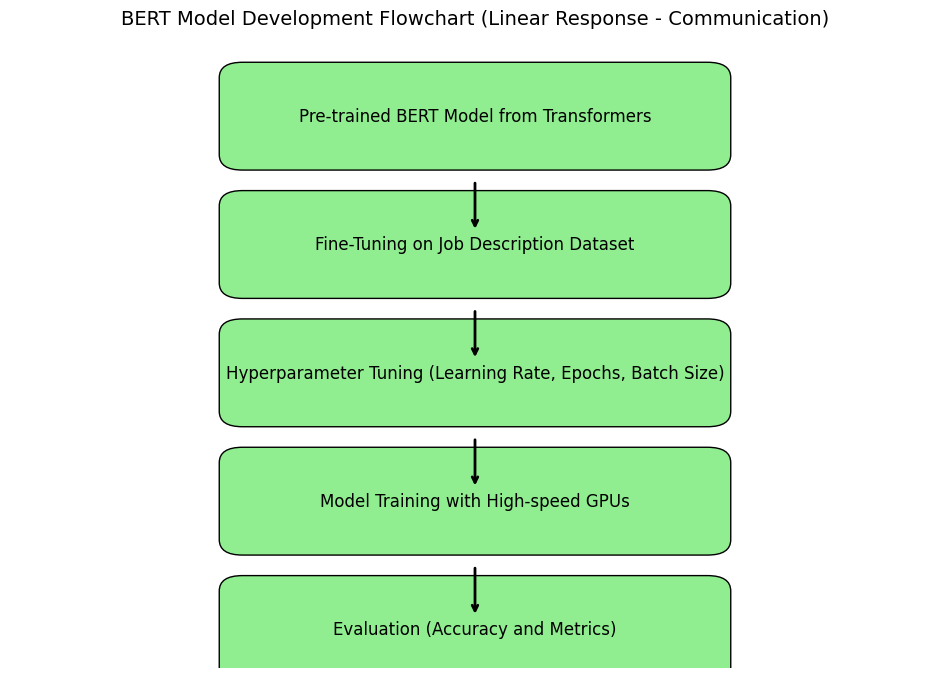

In [21]:
# Importing required libraries for the BERT flowchart
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Function to add boxes for each model development step for BERT
def add_box(ax, text, xy, box_color='lightgreen'):
    # Create a rounded box for each step
    box = FancyBboxPatch((xy[0], xy[1]), 6, 1.5, boxstyle="round,pad=0.3", ec="black", fc=box_color)
    ax.add_patch(box)
    # Add text inside the box
    ax.text(xy[0] + 3, xy[1] + 0.75, text, va='center', ha='center', fontsize=12)

# Function to draw arrows between steps
def add_arrow(ax, start, end):
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2))

# Set up the figure and axes for the BERT model development flowchart
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

# Add boxes for each step in the BERT model development process
add_box(ax, "Pre-trained BERT Model from Transformers", (3, 10))
add_box(ax, "Fine-Tuning on Job Description Dataset", (3, 7.5))
add_box(ax, "Hyperparameter Tuning (Learning Rate, Epochs, Batch Size)", (3, 5))
add_box(ax, "Model Training with High-speed GPUs", (3, 2.5))
add_box(ax, "Evaluation (Accuracy and Metrics)", (3, 0))

# Add arrows between the steps
add_arrow(ax, (6, 9.5), (6, 8.5))
add_arrow(ax, (6, 7), (6, 6))
add_arrow(ax, (6, 4.5), (6, 3.5))
add_arrow(ax, (6, 2), (6, 1))

# Hide the axis
ax.set_axis_off()

# Add title
ax.set_title("BERT Model Development Flowchart (Linear Response - Communication)", fontsize=14, pad=20)

# Show the plot
plt.show()


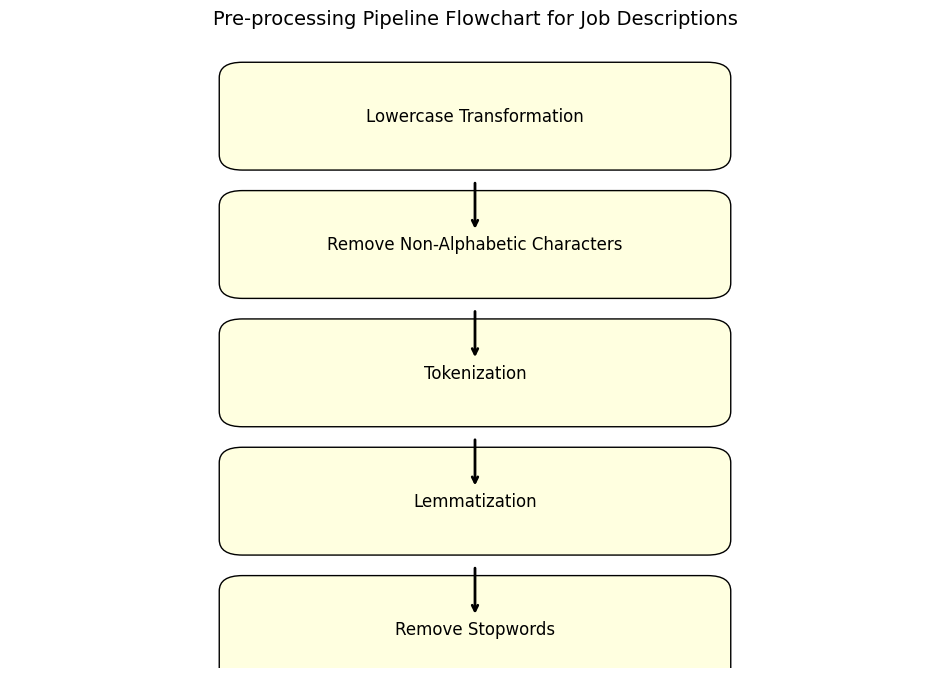

In [22]:
# Importing required libraries for the Preprocessing Pipeline flowchart
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Function to add boxes for each step in the preprocessing pipeline
def add_box(ax, text, xy, box_color='lightyellow'):
    # Create a rounded box for each step
    box = FancyBboxPatch((xy[0], xy[1]), 6, 1.5, boxstyle="round,pad=0.3", ec="black", fc=box_color)
    ax.add_patch(box)
    # Add text inside the box
    ax.text(xy[0] + 3, xy[1] + 0.75, text, va='center', ha='center', fontsize=12)

# Function to draw arrows between steps
def add_arrow(ax, start, end):
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2))

# Set up the figure and axes for the Pre-processing Pipeline flowchart
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

# Add boxes for each step in the Preprocessing Pipeline
add_box(ax, "Lowercase Transformation", (3, 10))
add_box(ax, "Remove Non-Alphabetic Characters", (3, 7.5))
add_box(ax, "Tokenization", (3, 5))
add_box(ax, "Lemmatization", (3, 2.5))
add_box(ax, "Remove Stopwords", (3, 0))

# Add arrows between the steps
add_arrow(ax, (6, 9.5), (6, 8.5))
add_arrow(ax, (6, 7), (6, 6))
add_arrow(ax, (6, 4.5), (6, 3.5))
add_arrow(ax, (6, 2), (6, 1))

# Hide the axis
ax.set_axis_off()

# Add title
ax.set_title("Pre-processing Pipeline Flowchart for Job Descriptions", fontsize=14, pad=20)

# Show the plot
plt.show()


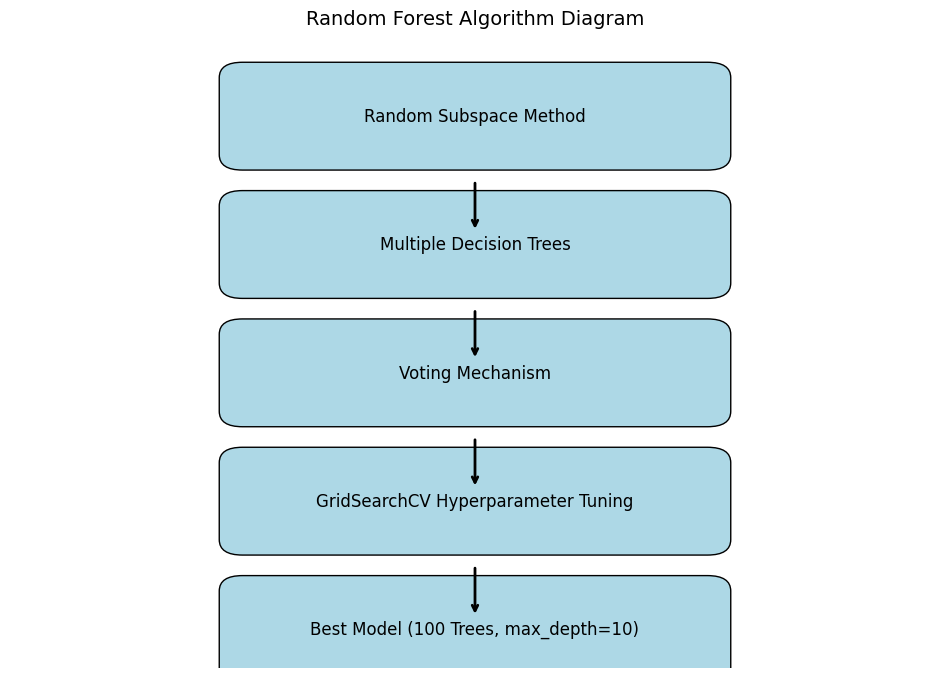

In [23]:
# Importing required libraries for Random Forest and BERT diagrams
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Function to add boxes for each step in the model process
def add_box(ax, text, xy, box_color):
    # Create a rounded box for each step
    box = FancyBboxPatch((xy[0], xy[1]), 6, 1.5, boxstyle="round,pad=0.3", ec="black", fc=box_color)
    ax.add_patch(box)
    # Add text inside the box
    ax.text(xy[0] + 3, xy[1] + 0.75, text, va='center', ha='center', fontsize=12)

# Function to draw arrows between steps
def add_arrow(ax, start, end):
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2))

# 1. Diagram for Random Forest Algorithm
fig_rf, ax_rf = plt.subplots(figsize=(12, 8))
ax_rf.set_xlim(0, 12)
ax_rf.set_ylim(0, 12)

# Add boxes for each step in Random Forest Algorithm
add_box(ax_rf, "Random Subspace Method", (3, 10), 'lightblue')
add_box(ax_rf, "Multiple Decision Trees", (3, 7.5), 'lightblue')
add_box(ax_rf, "Voting Mechanism", (3, 5), 'lightblue')
add_box(ax_rf, "GridSearchCV Hyperparameter Tuning", (3, 2.5), 'lightblue')
add_box(ax_rf, "Best Model (100 Trees, max_depth=10)", (3, 0), 'lightblue')

# Add arrows between steps
add_arrow(ax_rf, (6, 9.5), (6, 8.5))
add_arrow(ax_rf, (6, 7), (6, 6))
add_arrow(ax_rf, (6, 4.5), (6, 3.5))
add_arrow(ax_rf, (6, 2), (6, 1))

# Hide the axis
ax_rf.set_axis_off()
ax_rf.set_title("Random Forest Algorithm Diagram", fontsize=14, pad=20)

# Show the diagram
plt.show()


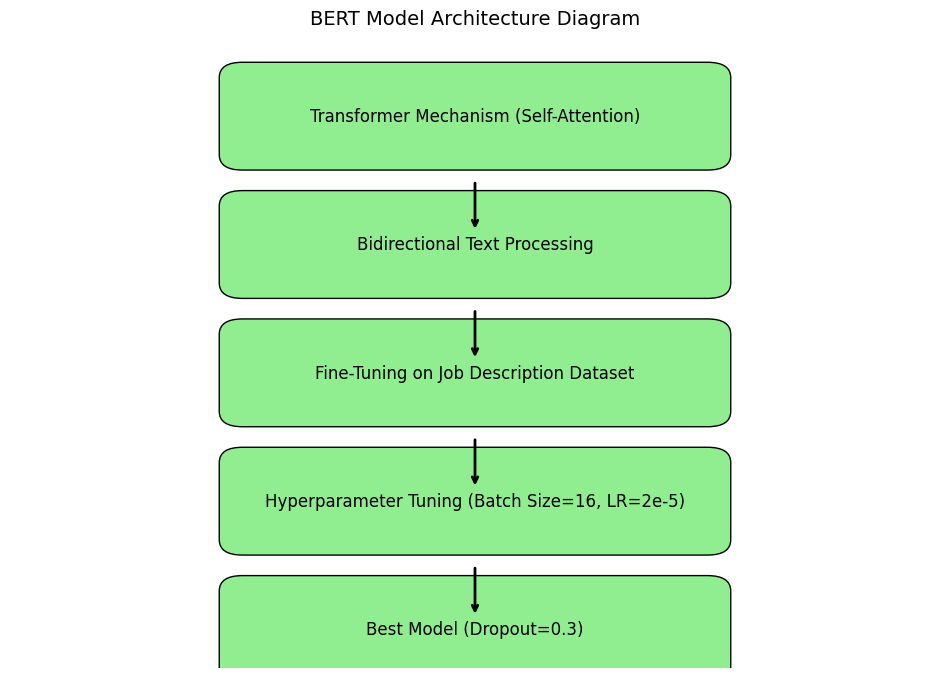

In [24]:
# 2. Diagram for BERT Architecture
fig_bert, ax_bert = plt.subplots(figsize=(12, 8))
ax_bert.set_xlim(0, 12)
ax_bert.set_ylim(0, 12)

# Add boxes for each step in BERT Architecture
add_box(ax_bert, "Transformer Mechanism (Self-Attention)", (3, 10), 'lightgreen')
add_box(ax_bert, "Bidirectional Text Processing", (3, 7.5), 'lightgreen')
add_box(ax_bert, "Fine-Tuning on Job Description Dataset", (3, 5), 'lightgreen')
add_box(ax_bert, "Hyperparameter Tuning (Batch Size=16, LR=2e-5)", (3, 2.5), 'lightgreen')
add_box(ax_bert, "Best Model (Dropout=0.3)", (3, 0), 'lightgreen')

# Add arrows between steps
add_arrow(ax_bert, (6, 9.5), (6, 8.5))
add_arrow(ax_bert, (6, 7), (6, 6))
add_arrow(ax_bert, (6, 4.5), (6, 3.5))
add_arrow(ax_bert, (6, 2), (6, 1))

# Hide the axis
ax_bert.set_axis_off()
ax_bert.set_title("BERT Model Architecture Diagram", fontsize=14, pad=20)

# Show the diagram
plt.show()